Task 1

=== Gradient Check ===
Checking W1...
W1 passed gradient check!
=== Feedforward Neural Network Demo ===
Solving XOR problem...
Network architecture: 2 -> 4 -> 1
Training...
Epoch 100/2000, Loss: 0.125119
Epoch 200/2000, Loss: 0.125059
Epoch 300/2000, Loss: 0.125017
Epoch 400/2000, Loss: 0.124982
Epoch 500/2000, Loss: 0.124946
Epoch 600/2000, Loss: 0.124904
Epoch 700/2000, Loss: 0.124846
Epoch 800/2000, Loss: 0.124755
Epoch 900/2000, Loss: 0.124600
Epoch 1000/2000, Loss: 0.124313
Epoch 1100/2000, Loss: 0.123742
Epoch 1200/2000, Loss: 0.122593
Epoch 1300/2000, Loss: 0.120391
Epoch 1400/2000, Loss: 0.116603
Epoch 1500/2000, Loss: 0.110902
Epoch 1600/2000, Loss: 0.103679
Epoch 1700/2000, Loss: 0.095912
Epoch 1800/2000, Loss: 0.087838
Epoch 1900/2000, Loss: 0.078536
Epoch 2000/2000, Loss: 0.066646

=== Testing Results ===
Input: [0 0] | Expected: 0 | Predicted: 0.2129
Input: [0 1] | Expected: 1 | Predicted: 0.6314
Input: [1 0] | Expected: 1 | Predicted: 0.6666
Input: [1 1] | Expected: 0 | P

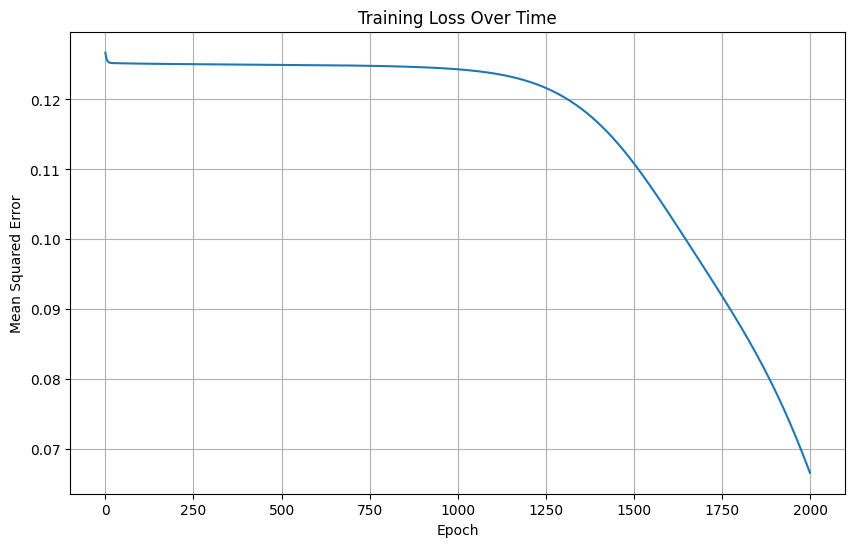


=== Network Parameters ===
Weights W1 (Input -> Hidden):
[[ 0.79614048  0.86123761 -3.89838682 -0.76759063]
 [ 0.67820839  0.29237903 -4.04487787 -1.3379088 ]]

Biases b1 (Hidden layer):
[[-0.49116623 -0.14482294  0.7479058   1.04905363]]

Weights W2 (Hidden -> Output):
[[-1.12378647]
 [-0.76487759]
 [-4.32533801]
 [ 2.21561816]]

Biases b2 (Output layer):
[[0.76845654]]


In [10]:
import numpy as np
import matplotlib.pyplot as plt

class FeedforwardNeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Initialize the feedforward neural network with 3 layers.
        
        Args:
            input_size (int): Number of neurons in input layer
            hidden_size (int): Number of neurons in hidden layer
            output_size (int): Number of neurons in output layer
            learning_rate (float): Learning rate for training
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights randomly with small values
        # Weights between input and hidden layer
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.5
        # Weights between hidden and output layer
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.5
        
        # Initialize biases
        self.b1 = np.zeros((1, self.hidden_size))
        self.b2 = np.zeros((1, self.output_size))
        
        # Store activations for backpropagation
        self.z1 = None  # Hidden layer input (before activation)
        self.a1 = None  # Hidden layer output (after activation)
        self.z2 = None  # Output layer input (before activation)
        self.a2 = None  # Output layer output (after activation)
    
    def sigmoid(self, x):
        """
        Sigmoid activation function.
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Sigmoid of input
        """
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        Derivative of sigmoid function.
        
        Args:
            x (numpy.ndarray): Input array (output of sigmoid)
            
        Returns:
            numpy.ndarray: Derivative of sigmoid
        """
        return x * (1 - x)
    
    def forward(self, X):
        """
        Forward propagation through the network.
        
        Args:
            X (numpy.ndarray): Input data of shape (samples, features)
            
        Returns:
            numpy.ndarray: Output predictions
        """
        # Input to hidden layer
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        
        # Hidden to output layer
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        
        return self.a2
    
    # ===== Project01_NN · Task 4: backpropagation algorithm =====
    def backprop(self, X, y, output):
        """
        Compute gradients for a mini-batch and RETURN them (do NOT update parameters).
        Shapes follow your current convention.
        """
        m = X.shape[0]

        # output_error = a - y
        output_error = output - y                                # (m, output_size)
        output_delta = output_error * self.sigmoid_derivative(output)   # (m, output_size)

        dW2 = self.a1.T.dot(output_delta) / m                   # (hidden_size, output_size)
        db2 = np.sum(output_delta, axis=0, keepdims=True) / m   # (1, output_size)

        hidden_error = output_delta.dot(self.W2.T)              # (m, hidden_size)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.a1)  # (m, hidden_size)

        dW1 = X.T.dot(hidden_delta) / m                         # (input_size, hidden_size)
        db1 = np.sum(hidden_delta, axis=0, keepdims=True) / m   # (1, hidden_size)

        return dW1, db1, dW2, db2


    def train(self, X, y, epochs=1000, verbose=True):
        """
        Train the neural network using backpropagation.
        
        Args:
            X (numpy.ndarray): Training input data
            y (numpy.ndarray): Training labels
            epochs (int): Number of training epochs
            verbose (bool): Whether to print training progress
            
        Returns:
            list: Training loss history
        """
        loss_history = []
        
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward(X)
            
            # Calculate loss (Mean Squared Error)
            # loss = np.mean((output - y) ** 2)
            loss = 0.5 * np.mean(np.sum((output - y) ** 2, axis=1))
            loss_history.append(loss)
            
            # Backward propagation
            dW1, db1, dW2, db2 = self.backprop(X, y, output)
            self.W2 -= self.learning_rate * dW2
            self.b2 -= self.learning_rate * db2
            self.W1 -= self.learning_rate * dW1
            self.b1 -= self.learning_rate * db1

            
            # Print progress
            if verbose and (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.6f}")
        
        return loss_history    

    def predict(self, X):
        """
        Make predictions on new data.
        
        Args:
            X (numpy.ndarray): Input data
            
        Returns:
            numpy.ndarray: Predictions
        """
        return self.forward(X)
        
    def get_parameters(self):
        """
        Get current network parameters.
        
        Returns:
            dict: Dictionary containing weights and biases
        """
        return {
            'W1': self.W1,
            'b1': self.b1,
            'W2': self.W2,
            'b2': self.b2
        }
    
    def set_parameters(self, params):
        """
        Set network parameters.
        
        Args:
            params (dict): Dictionary containing weights and biases
        """
        self.W1 = params['W1']
        self.b1 = params['b1']
        self.W2 = params['W2']
        self.b2 = params['b2']

def gradient_check(nn, X, y, epsilon=1e-5, tolerance=1e-6):
    """
    Compare backprop gradients with numerical gradients (finite differences).
    """
    output = nn.forward(X)
    dW1, db1, dW2, db2 = nn.backprop(X, y, output)

    def loss_fn():
        out = nn.forward(X)
        return 0.5 * np.mean(np.sum((out - y) ** 2, axis=1))


    print("Checking W1...")
    for i in range(nn.W1.shape[0]):
        for j in range(nn.W1.shape[1]):
            orig = nn.W1[i, j]
            nn.W1[i, j] = orig + epsilon
            loss_plus = loss_fn()
            nn.W1[i, j] = orig - epsilon
            loss_minus = loss_fn()
            nn.W1[i, j] = orig  # reset
            num_grad = (loss_plus - loss_minus) / (2 * epsilon)
            rel_error = abs(num_grad - dW1[i, j]) / (abs(num_grad) + abs(dW1[i, j]) + 1e-12)
            if rel_error > tolerance:
                print(f"  Gradient check failed at W1[{i},{j}]: "
                      f"num={num_grad:.6e}, backprop={dW1[i,j]:.6e}, rel_error={rel_error:.2e}")
                return False

    print("W1 passed gradient check!")
    return True


#below is a simple test for training, you need change according to your corresponding tasks
if __name__ == "__main__":
    print("=== Gradient Check ===")
    nn_test = FeedforwardNeuralNetwork(input_size=2, hidden_size=2, output_size=1, learning_rate=0.1)
    X_small = np.array([[0, 1],
                        [1, 0]])
    y_small = np.array([[1],
                        [1]])

    gradient_check(nn_test, X_small, y_small)
    # Generate sample data for XOR problem
    print("=== Feedforward Neural Network Demo ===")
    print("Solving XOR problem...")
    
    # XOR dataset
    X = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])
    
    y = np.array([[0],
                  [1],
                  [1],
                  [0]])
    
    # Create and train the neural network
    nn = FeedforwardNeuralNetwork(input_size=2, hidden_size=4, output_size=1, learning_rate=1.0)
    
    print(f"Network architecture: {nn.input_size} -> {nn.hidden_size} -> {nn.output_size}")
    print("Training...")
    
    # Train the network
    loss_history = nn.train(X, y, epochs=2000, verbose=True)
    
    # Test the trained network
    print("\n=== Testing Results ===")
    predictions = nn.predict(X)
    
    for i in range(len(X)):
        print(f"Input: {X[i]} | Expected: {y[i][0]} | Predicted: {predictions[i][0]:.4f}")
    
    # Calculate accuracy (for binary classification)
    binary_predictions = (predictions > 0.5).astype(int)
    accuracy = np.mean(binary_predictions == y)
    print(f"\nAccuracy: {accuracy * 100:.2f}%")
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.grid(True)
    plt.show()
    
    # Display network parameters
    print("\n=== Network Parameters ===")
    params = nn.get_parameters()
    print("Weights W1 (Input -> Hidden):")
    print(params['W1'])
    print("\nBiases b1 (Hidden layer):")
    print(params['b1'])
    print("\nWeights W2 (Hidden -> Output):")
    print(params['W2'])
    print("\nBiases b2 (Output layer):")
    print(params['b2'])



In [11]:
# ===== Project01_NN · Task 3: Mini-batch SGD training =====
import numpy as np

class FeedforwardNeuralNetwork_SGD(FeedforwardNeuralNetwork):
    """
    Extend the original network with mini-batch SGD training.
    """
    def train_sgd(self, X, y, epochs=10, batch_size=32, shuffle=True, verbose=True):
        n = X.shape[0]
        loss_history = []

        for epoch in range(1, epochs + 1):
            # shuffle data at the beginning of each epoch
            if shuffle:
                perm = np.random.permutation(n)
                X_epoch = X[perm]
                y_epoch = y[perm]
            else:
                X_epoch = X
                y_epoch = y

            total_loss = 0.0
            # iterate over mini-batches
            for start in range(0, n, batch_size):
                end = min(start + batch_size, n)
                xb = X_epoch[start:end]
                yb = y_epoch[start:end]

                out = self.forward(xb)
                # batch_loss = np.mean((out - yb) ** 2)
                batch_loss = 0.5 * np.mean(np.sum((out - yb) ** 2, axis=1))
                total_loss += batch_loss * (end - start)

                # update parameters using backpropagation
                dW1, db1, dW2, db2 = self.backprop(xb, yb, out)
                self.W2 -= self.learning_rate * dW2
                self.b2 -= self.learning_rate * db2
                self.W1 -= self.learning_rate * dW1
                self.b1 -= self.learning_rate * db1


            epoch_loss = total_loss / n
            loss_history.append(epoch_loss)
            if verbose:
                print(f"Epoch {epoch}/{epochs} | batch_size={batch_size} | MSE: {epoch_loss:.6f}")

        return loss_history


# Example usage with XOR dataset:
# nn_sgd = FeedforwardNeuralNetwork_SGD(input_size=2, hidden_size=4, output_size=1, learning_rate=1.0)
# loss_hist = nn_sgd.train_sgd(X, y, epochs=2000, batch_size=2, verbose=True)
# 
# pred = nn_sgd.predict(X)
# print(pred)



